In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

import os
import sys

notebook_dir = os.getcwd()  

emotions_dir   = os.path.abspath(os.path.join(notebook_dir, "..", "..", "emotions"))

evaluation_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

for d in (emotions_dir, evaluation_dir):
    if d not in sys.path:
        sys.path.insert(0, d)

from emotions import emotions_labels
from utils import predict_one, load_similarity_matrix, plot_confusion, predict_two, align_predictions_with_labels, print_header


/home/bryan/miniconda3/envs/env_nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
RESULTS_STORAGE_PATH = "sentiment_results"
CSV_PROMPTS_PATH = "eval_prompts.csv"
CSV_LYRICS_LABELS_PATH = "eval_lyrics_labels.csv"
IDX = {lbl: i for i, lbl in enumerate(emotions_labels)}

## Hard evaluation

                                                text       label  \
0  Watching my teammate stay late to coach the in...  admiration   
1  That clip of a golden retriever chasing bubble...   amusement   
2  The courier dumped my brand-new keyboard in a ...       anger   
3  The elevator keeps dinging on every floor even...   annoyance   
4  My colleague refactored the legacy code and no...    approval   

             pred  
0      admiration  
1       amusement  
2       annoyance  
3  disappointment  
4        approval  
Hard accuracy : 0.324


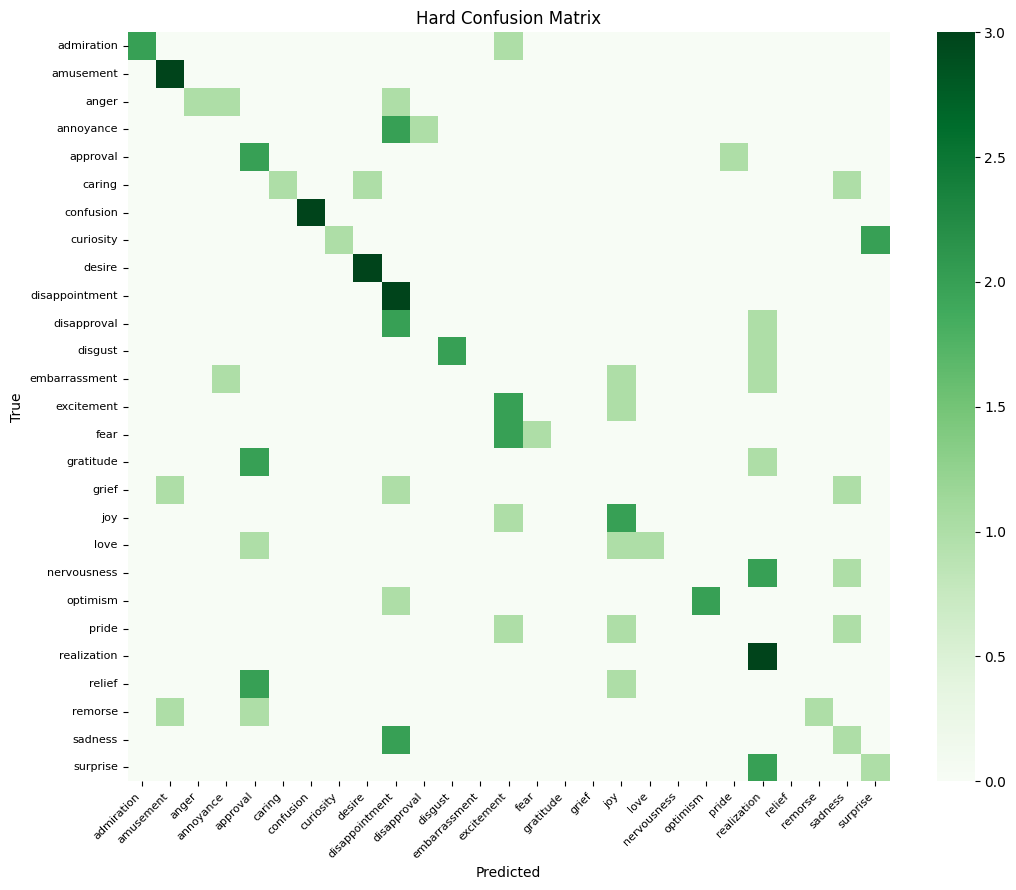

In [3]:
df = pd.read_csv(CSV_PROMPTS_PATH)
df["pred"] = df["text"].apply(predict_one)
print(df.head())
y_true = df["label"].values
y_pred = df["pred"].values
hard_acc = accuracy_score(y_true, y_pred)
hard_cm  = confusion_matrix(y_true, y_pred, labels=emotions_labels)

print(f"Hard accuracy : {hard_acc:.3f}")
plot_confusion(hard_cm, emotions_labels,
                title="Hard Confusion Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "cm_hard.png"),
                vmax=hard_cm.max())

In [4]:
report = classification_report(df["label"], df["pred"], digits=3, zero_division=0)
report_path = os.path.join(RESULTS_STORAGE_PATH, "classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
print(f"Classification report saved to {report_path}")
print("report:")
print(report)

Classification report saved to sentiment_results/classification_report.txt
report:
                   precision    recall  f1-score   support

     "admiration"      0.000     0.000     0.000         1
      "amusement"      0.000     0.000     0.000         1
          "anger"      0.000     0.000     0.000         1
      "annoyance"      0.000     0.000     0.000         1
       "approval"      0.000     0.000     0.000         1
         "caring"      0.000     0.000     0.000         1
      "confusion"      0.000     0.000     0.000         1
      "curiosity"      0.000     0.000     0.000         1
         "desire"      0.000     0.000     0.000         1
 "disappointment"      0.000     0.000     0.000         1
    "disapproval"      0.000     0.000     0.000         1
        "disgust"      0.000     0.000     0.000         1
  "embarrassment"      0.000     0.000     0.000         1
     "excitement"      0.000     0.000     0.000         1
           "fear"      0.000   

## Soft evaluation

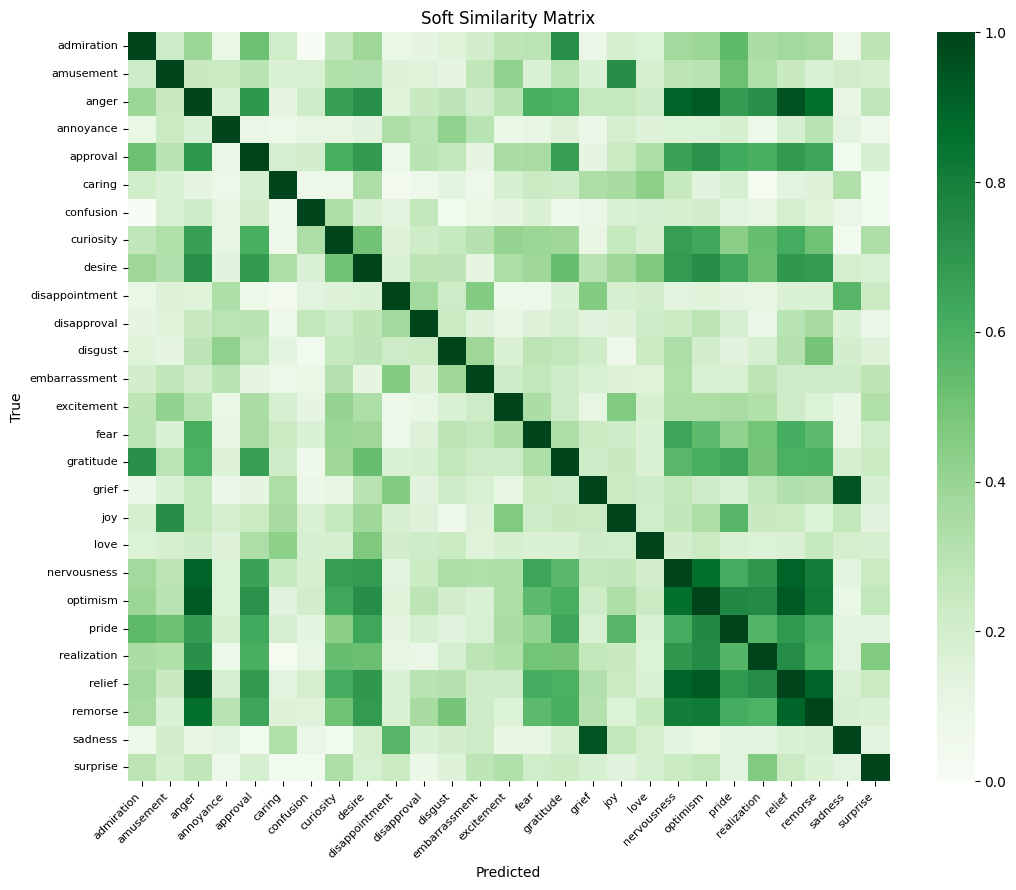

Soft accuracy : 0.683


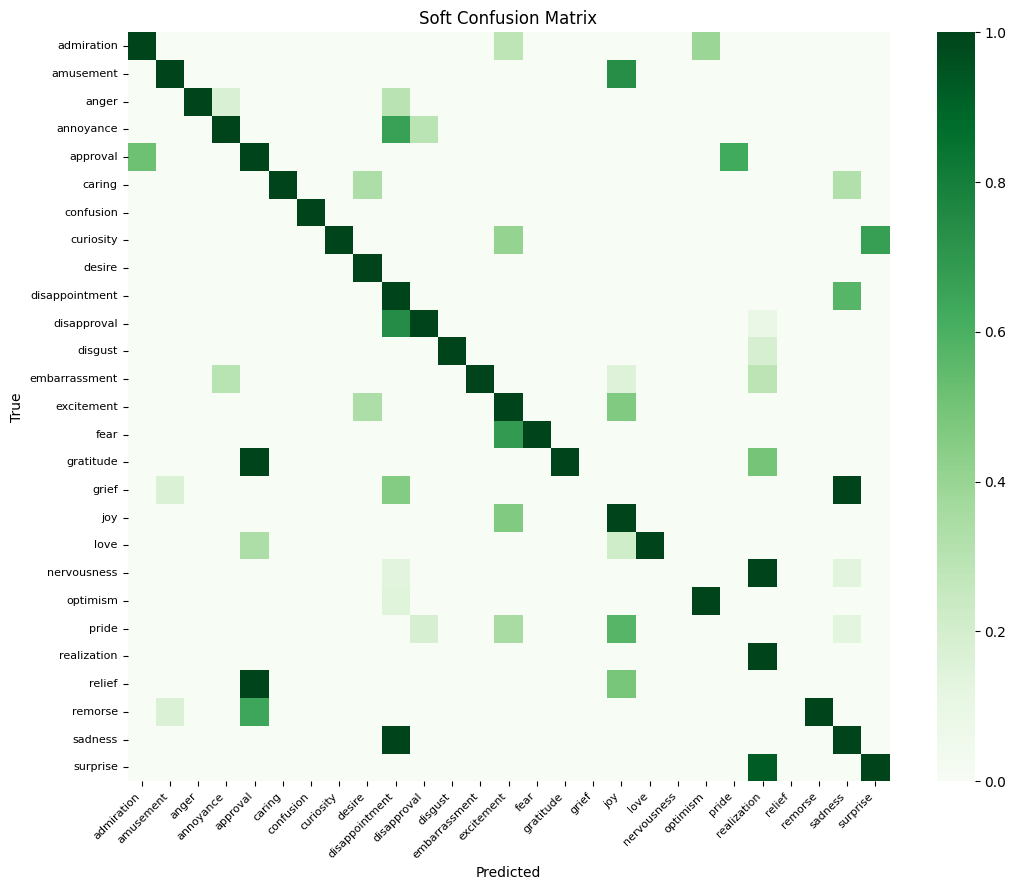

In [5]:
S = load_similarity_matrix()
plot_confusion(S, emotions_labels,
                title="Soft Similarity Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "cm_soft_similarity.png"),
                vmax=S.max(), save=False)

y_true = [label.strip().replace('"', '') for label in y_true]

soft_scores = [S[IDX[t], IDX[p]] for t, p in zip(y_true, y_pred)]
soft_acc    = np.mean(soft_scores)
print(f"Soft accuracy : {soft_acc:.3f}")
soft_cm = np.zeros_like(S)
for t, p in zip(y_true, y_pred):
    soft_cm[IDX[t], IDX[p]] += S[IDX[t], IDX[p]]

plot_confusion(soft_cm, emotions_labels,
                title="Soft Confusion Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "cm_soft.png"), vmax=1.0)

df.to_csv(os.path.join(RESULTS_STORAGE_PATH, "eval_prompts_with_preds.csv"), index=False)

## Evaluation 2: Sentiments detected from songs

y_true_flat: ['caring', 'love', 'anger', 'disapproval', 'sadness', 'disappointment', 'disappointment', 'remorse', 'desire', 'confusion', 'love', 'relief', 'optimism', 'curiosity', 'anger', 'confusion', 'disappointment', 'pride', 'caring', 'relief', 'desire', 'sadness', 'confusion', 'fear', 'remorse', 'disapproval', 'sadness', 'fear', 'sadness', 'desire', 'remorse', 'love', 'realization', 'sadness', 'desire', 'love', 'sadness', 'confusion', 'desire', 'excitement', 'desire', 'love', 'sadness', 'love', 'gratitude', 'amusement', 'disappointment', 'sadness', 'grief', 'remorse', 'confusion', 'admiration', 'pride', 'amusement', 'sadness', 'remorse', 'amusement', 'admiration', 'excitement', 'anger', 'disapproval', 'confusion', 'optimism', 'love', 'optimism', 'pride', 'sadness', 'disappointment', 'love', 'optimism', 'sadness', 'anger', 'remorse', 'sadness', 'sadness', 'anger', 'anger', 'fear', 'love', 'optimism', 'gratitude', 'joy', 'grief', 'sadness', 'confusion', 'disappointment', 'anger', 'g

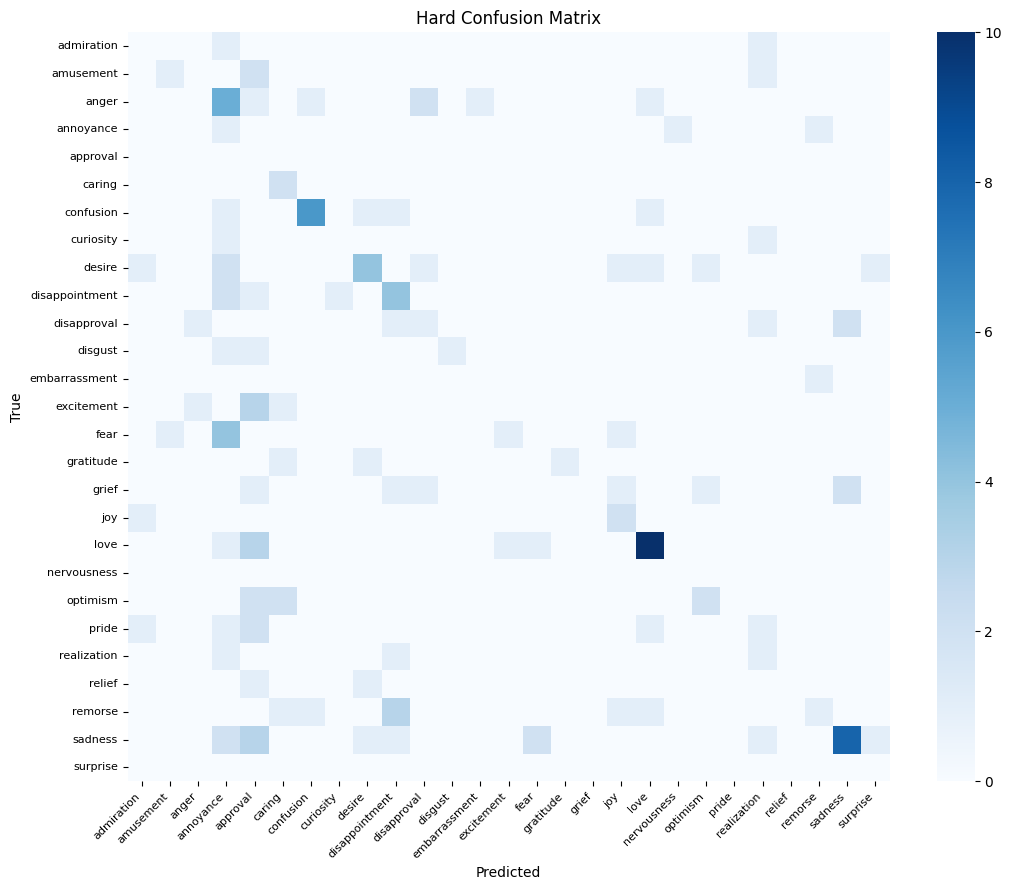

In [17]:
df = pd.read_csv(CSV_LYRICS_LABELS_PATH)
df["pred"] = df["lyric"].apply(predict_two)  # predict_two devuelve una lista de dos emociones

y_true_label1 = df["label1"].values
y_true_label2 = df["label2"].values

y_true = list(zip(y_true_label1, y_true_label2))  
y_pred = df["pred"].values 

aligned_pairs = [align_predictions_with_labels(pred, real) for pred, real in zip(y_pred, y_true)]

y_pred_aligned = [pair[0] for pair in aligned_pairs]
y_true_aligned = [pair[1] for pair in aligned_pairs]

y_true_flat = [label for pair in y_true_aligned for label in pair]
y_pred_flat = [label for pair in y_pred_aligned for label in pair]

print(f"y_true_flat: {y_true_flat}")
print(f"y_pred_flat: {y_pred_flat}")

hard_acc = accuracy_score(y_true_flat, y_pred_flat)
print(f"Hard accuracy : {hard_acc:.3f}")

# Generate confusion matrix for lyrics
hard_cm = confusion_matrix(y_true_flat, y_pred_flat, labels=emotions_labels)

plot_confusion(
    hard_cm, emotions_labels,
    title="Hard Confusion Matrix",
    fname=os.path.join(RESULTS_STORAGE_PATH, "lyrics_hard_acc.png"),
    vmax=hard_cm.max()
)

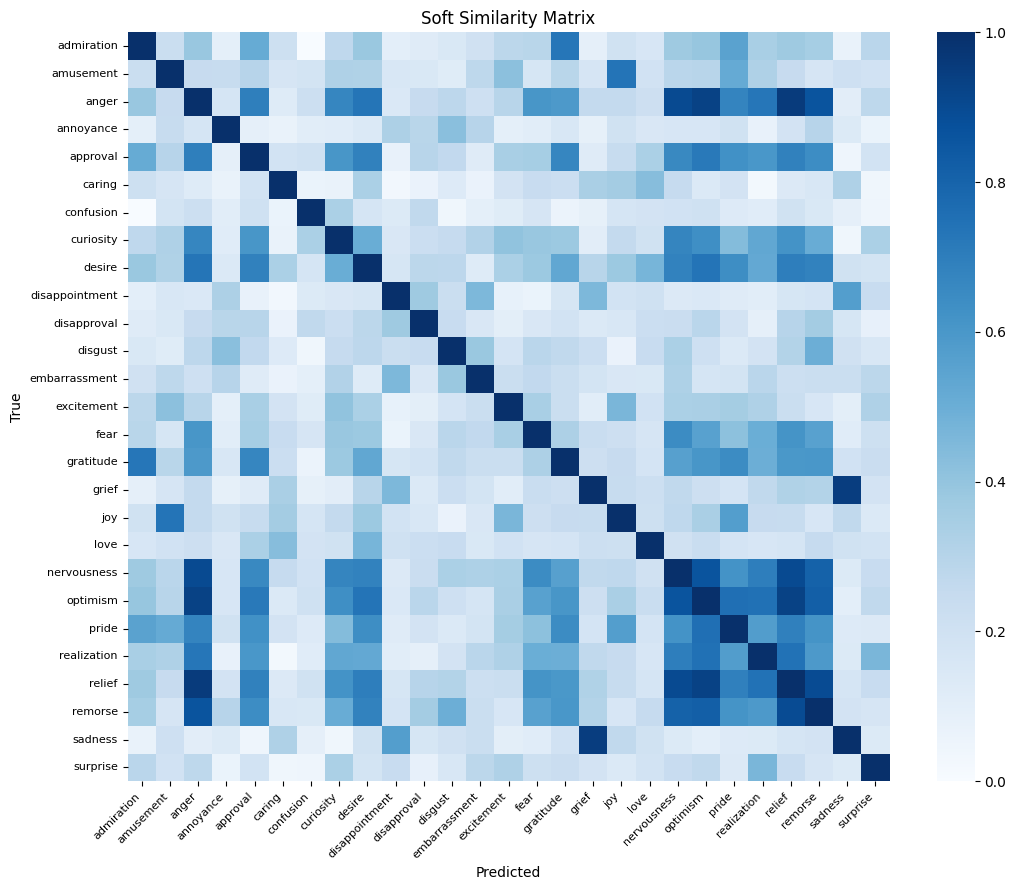

Soft accuracy : 0.468


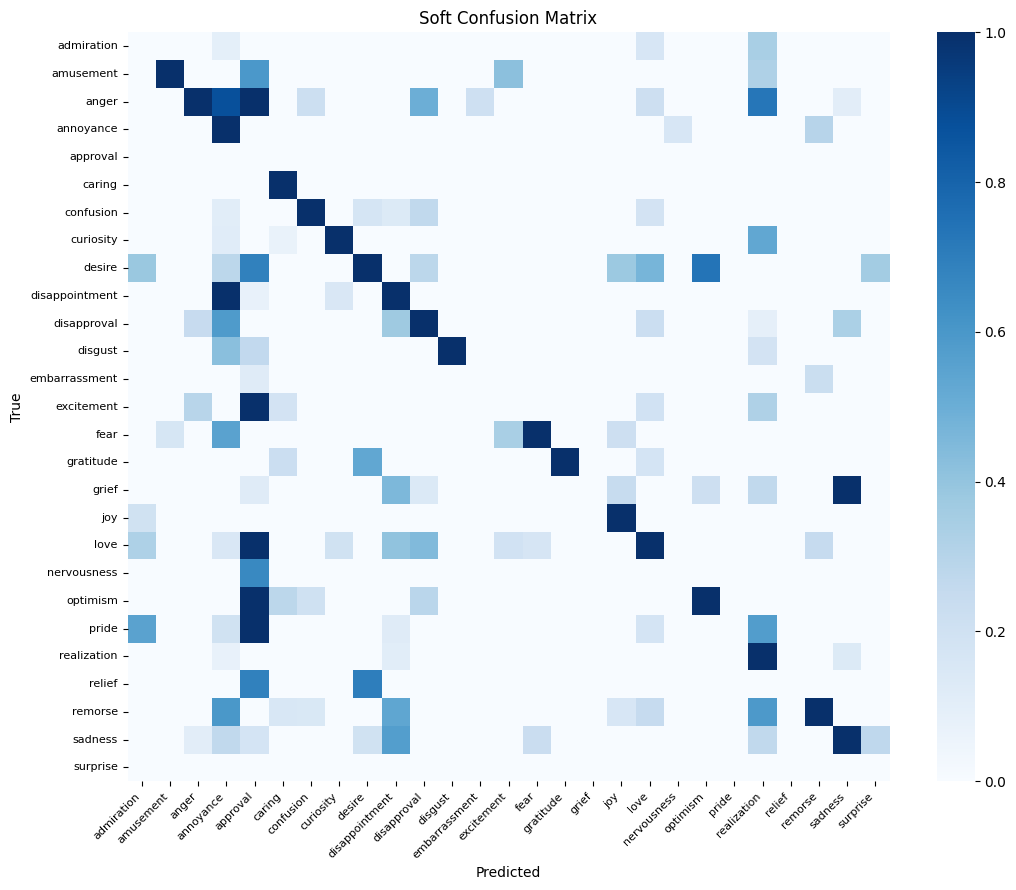

In [18]:
S = load_similarity_matrix()
plot_confusion(S, emotions_labels,
                title="Soft Similarity Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "lyrics_soft_similarity.png"),
                vmax=S.max(), save=False)

y_true_aligned = [[label.strip() for label in pair] for pair in y_true_aligned]
y_pred_aligned = [[label.strip() for label in pair] for pair in y_pred_aligned]

soft_scores = [S[IDX[t], IDX[p]] for t_pair, p_pair in zip(y_true_aligned, y_pred_aligned) for t, p in zip(t_pair, p_pair)]
soft_acc  = np.mean(soft_scores)
print(f"Soft accuracy : {soft_acc:.3f}")
soft_cm = np.zeros_like(S)
for t_pair, p_pair in zip(y_true_aligned, y_pred_aligned):
    for t, p in zip(t_pair, p_pair):
        soft_cm[IDX[t], IDX[p]] += S[IDX[t], IDX[p]]

plot_confusion(soft_cm, emotions_labels,
                title="Soft Confusion Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "lyrics_soft.png"), vmax=1.0)


df.to_csv(os.path.join(RESULTS_STORAGE_PATH, "eval_prompts_with_preds.csv"), index=False)